# Batch effect correction
In this tutorial, we will perform the entire `scMGCA` batch effect correction using the human pancreatic dataset (can be downloaded <a href="https://github.com/Philyzh8/scMGCA/tree/master/dataset/pancreas">here</a>).

## Import python package

In [ ]:
import os
import argparse
import pandas as pd
import tensorflow as tf
from spektral.layers import GraphConv
from sklearn import metrics
from numpy.random import seed
seed(1)
tf.random.set_seed(1)
# Remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# scMGCA module
from scMGCA.preprocess import *
from scMGCA.utils import *
from scMGCA.scmgca import SCMGCA, SCMGCAL
from scMGCA.losses import *
from scMGCA.graph_function import *

## Parameter settings

In [2]:
parser = argparse.ArgumentParser(description="train", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--dataname", default = "pancreas", type = str)
parser.add_argument("--highly_genes", default = 2000, type=int)
parser.add_argument("--pretrain_epochs", default = 1000, type=int)
parser.add_argument("--maxiter", default = 300, type=int)
args = parser.parse_args(args=['--dataname', 'pancreas', '--highly_genes', '2000', '--pretrain_epochs', '1000', '--maxiter', '300'])

## Read data

In [3]:
adata = read_pancreas("./dataset/pancreas", cache=True)
y = np.array(adata.obs['celltype'].values, dtype=str)
cluster_number = len(np.unique(y))
print("Cell number:", adata.X.shape[0])
print("Gene number",adata.X.shape[1])   
print("Cluster number:", cluster_number)

View of AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'
    var: 'genename', 'n_cells'
Cell number: 6321
Gene number 21215
Cluster number: 13


## Data preprocessing

In [ ]:
count = normalize_batch(adata, batch_key = 'tech', n_high_var = args.highly_genes)  

## Construct cell graph

In [ ]:
adj = get_adj(count)
adj_n = GraphConv.preprocess(adj)

## Pre-training

In [6]:
model = SCMGCA(count, adj=adj, adj_n=adj_n, latent_dim=20, dec_dim=[128])
model.pre_train(epochs=args.pretrain_epochs, W_a=0.6, lr=5e-4)
latent_pre = model.embedding(count, adj_n)

Epoch 10  Mult_loss: -0.059194803   A_rec_loss: 0.0053158654
Epoch 20  Mult_loss: -0.66634506   A_rec_loss: 0.006172923
Epoch 30  Mult_loss: -1.9341395   A_rec_loss: 0.006377106
Epoch 40  Mult_loss: -2.288747   A_rec_loss: 0.006401022
Epoch 50  Mult_loss: -2.546524   A_rec_loss: 0.0065452913
Epoch 60  Mult_loss: -2.700222   A_rec_loss: 0.0064924597
Epoch 70  Mult_loss: -2.791896   A_rec_loss: 0.0065031154
Epoch 80  Mult_loss: -2.8518136   A_rec_loss: 0.0064262873
Epoch 90  Mult_loss: -2.892231   A_rec_loss: 0.0063656326
Epoch 100  Mult_loss: -2.9193466   A_rec_loss: 0.0063509066
Epoch 110  Mult_loss: -2.9448931   A_rec_loss: 0.0063002585
Epoch 120  Mult_loss: -2.9716494   A_rec_loss: 0.006254684
Epoch 130  Mult_loss: -2.9934814   A_rec_loss: 0.0062246686
Epoch 140  Mult_loss: -3.0111663   A_rec_loss: 0.006201898
Epoch 150  Mult_loss: -3.0263383   A_rec_loss: 0.0061896513
Epoch 160  Mult_loss: -3.0405831   A_rec_loss: 0.006165742
Epoch 170  Mult_loss: -3.0542946   A_rec_loss: 0.00617075

## Training

In [7]:
adata_latent = sc.AnnData(latent_pre)
sc.pp.neighbors(adata_latent, n_neighbors = 15, use_rep="X")
resolution = find_resolution(adata_latent, 8, 0)
adata_latent = sc.tl.leiden(adata_latent, resolution = resolution, random_state = 0, copy = True)
Y_pred_init = np.asarray(adata_latent.obs['leiden'], dtype=int)
features = pd.DataFrame(adata_latent.X, index = np.arange(0, adata_latent.shape[0]))
Group = pd.Series(Y_pred_init, index = np.arange(0, adata_latent.shape[0]), name="Group")
Mergefeature = pd.concat([features, Group],axis=1)
centers = np.asarray(Mergefeature.groupby("Group").mean())
Cluster_predicted=model.train(epochs=args.maxiter, W_a=0.6, centers=centers)

Epoch 0  Mult_loss:  -3.3983047  A_rec_loss:  0.005139091  cluster_loss:  0.30853766
Epoch 10  Mult_loss:  -3.362367  A_rec_loss:  0.0051314016  cluster_loss:  0.28393573
Epoch 20  Mult_loss:  -3.348073  A_rec_loss:  0.0051306216  cluster_loss:  0.25683475
Epoch 30  Mult_loss:  -3.3281515  A_rec_loss:  0.0051304093  cluster_loss:  0.22971925
Epoch 40  Mult_loss:  -3.3103964  A_rec_loss:  0.0051305164  cluster_loss:  0.20474808
Epoch 50  Mult_loss:  -3.296382  A_rec_loss:  0.005130498  cluster_loss:  0.1829993
Epoch 60  Mult_loss:  -3.2862275  A_rec_loss:  0.005130288  cluster_loss:  0.16495347
Epoch 70  Mult_loss:  -3.2788794  A_rec_loss:  0.0051310314  cluster_loss:  0.15019557
Epoch 80  Mult_loss:  -3.2730694  A_rec_loss:  0.005130525  cluster_loss:  0.13781421
Epoch 90  Mult_loss:  -3.2685206  A_rec_loss:  0.0051300665  cluster_loss:  0.12742159
Epoch 100  Mult_loss:  -3.265227  A_rec_loss:  0.0051300274  cluster_loss:  0.11865937
Epoch 110  Mult_loss:  -3.2629097  A_rec_loss:  0.00

## Evaluation

In [8]:
y = list(map(str, y))
Cluster_predicted.y_pred = np.array(Cluster_predicted.y_pred)
nmi = metrics.normalized_mutual_info_score(y, Cluster_predicted.y_pred)
ari = metrics.adjusted_rand_score(y, Cluster_predicted.y_pred)
print('NMI= %.4f, ARI= %.4f' % (nmi, ari))

NMI= 0.9275, ARI= 0.9585


## Visualization

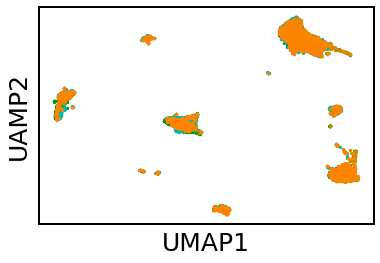

In [12]:
import matplotlib.pyplot as plt
import umap
latent = Cluster_predicted.latent
reducer = umap.UMAP(n_neighbors=20,metric='cosine',min_dist=0.01,random_state=42)
embedding = reducer.fit_transform(latent)
for i, x in enumerate(adata.obs['tech']):
    if x == 'celseq':
        s1 = plt.scatter(embedding[i][0], embedding[i][1], s=5, color='#019013')
    elif x == 'celseq2':
        s2 = plt.scatter(embedding[i][0], embedding[i][1], s=5, color='#FD8400')
    elif x == 'fluidigmc1':
        s3 = plt.scatter(embedding[i][0], embedding[i][1], s=5, color='#BD9001')
    elif x == 'smartseq2':
        s4 = plt.scatter(embedding[i][0], embedding[i][1], s=5, color='#00BAAC')

plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1', fontsize=25)
plt.ylabel('UAMP2', fontsize=25)

ax = plt.gca()
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)  
plt.show()